In [1]:
import pandas as pd
import numpy as np

# Read the cleaned file into a DataFrame
df = pd.read_csv('../data/bgg_rating_threshold.csv', sep=';', engine='c')

# Convert the 'bgg_user_rating' column to numeric
df['bgg_user_rating'] = ((pd.to_numeric(df['bgg_user_rating'], errors='coerce'))*10).astype(np.uint8)

print("done")

done


In [2]:
from scipy.sparse import coo_matrix,csr_matrix
from sklearn.decomposition import TruncatedSVD
data = list(df.itertuples(index=False, name=None))
# Alternatively, you can use df['item'], df['user'], and df['review_score'] directly.

# Create unique mappings for items and users
unique_items = sorted(df['bgg_id'].unique())
unique_users = sorted(df['bgg_user_name'].unique())

item_to_index = {item: idx for idx, item in enumerate(unique_items)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Prepare row indices, column indices, and data (review scores) using the DataFrame columns
rows = df['bgg_id'].map(item_to_index)
cols = df['bgg_user_name'].map(user_to_index)
scores = df['bgg_user_rating']

# Create a sparse matrix using the COO format:
sparse_matrix = csr_matrix(
    (scores, (rows, cols)),
    shape=(len(unique_items), len(unique_users))
)

# Optionally convert to CSR format for more efficient arithmetic operations
#sparse_matrix = sparse_matrix.tocsr()
print ("Sparse matrix created with shape:", sparse_matrix.shape)

Sparse matrix created with shape: (15906, 414036)


In [3]:
# # 1) Compute column sums and counts of stored entries
# col_sums   = np.bincount(sparse_matrix.indices, weights=sparse_matrix.data, minlength=sparse_matrix.shape[1])
# col_counts = np.bincount(sparse_matrix.indices, minlength=sparse_matrix.shape[1])

# # 2) Compute column means, with NaN for empty columns
# col_means = col_sums / col_counts
# col_means[col_counts == 0] = np.nan

# # 3) Convert sparse_matrix.data to float64 for compatibility
# sparse_matrix.data = sparse_matrix.data.astype(np.float64)

# # 4) Subtract the column means from each stored entry, in place
# sparse_matrix.data -= col_means[sparse_matrix.indices]

In [4]:
# Display the first 5 rows and columns of the sparse_matrix
print(sparse_matrix[:5, :5])

  (4, 2)	80


In [5]:
from sklearn.metrics.pairwise import cosine_similarity
sparse_matrix = cosine_similarity(sparse_matrix, dense_output=True)
np.fill_diagonal(sparse_matrix, 0)  # Set diagonal to zero

In [6]:
# Display the first 5 rows and columns of the sparse_matrix
print(sparse_matrix[:5, :5])

[[0.         0.05108589 0.2722212  0.12965767 0.27684299]
 [0.05108589 0.         0.05886841 0.04999076 0.08140764]
 [0.2722212  0.05886841 0.         0.09845479 0.31968716]
 [0.12965767 0.04999076 0.09845479 0.         0.09519474]
 [0.27684299 0.08140764 0.31968716 0.09519474 0.        ]]


In [7]:
Number_neighbors = 25

In [8]:
import umap
reducer = umap.UMAP(metric='precomputed',n_jobs=-1,min_dist=0.1,n_neighbors=Number_neighbors)
mapper=reducer.fit(np.asarray(1 - sparse_matrix))
coords=reducer.transform(np.asarray(1 - sparse_matrix))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
# Get the indices of the top 500 values for each row
top_500_indices = np.argsort(sparse_matrix, axis=1)[:, -Number_neighbors:]

In [10]:
# # Create a new matrix to store the data
filtered_matrix = np.zeros((top_500_indices.shape[0], top_500_indices.shape[1]))

# Populate the matrix with data from sparse_matrix
for row_idx in range(top_500_indices.shape[0]):
    filtered_matrix[row_idx] = sparse_matrix[row_idx, top_500_indices[row_idx]]  # Direct indexing for numpy.ndarray


In [11]:
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
namess=[]
idss=[]
i=0
for bgg_id in unique_items:   
    new_var = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]
    namee = new_var['name'].values[0]
    ide= new_var['id'].values[0]
    namess.append(namee)
    idss.append(ide)
    i=i+1

In [12]:
import igraph as ig

# Extract indices and distances from neigh
# indices, dist, _ = neigh
weightss = filtered_matrix

# Create an edge list with weights
edges = []
weights = []
for i, neighbors in enumerate(np.asarray(top_500_indices)):
    for j, neighbor in enumerate(neighbors):
        if i != neighbor:  # Avoid self-loops
            edges.append((i, neighbor))
            weights.append(weightss[i, j])

# Create the igraph graph
g = ig.Graph(edges=edges, edge_attrs={"weight": weights}, directed=False)
print(g.summary())


IGRAPH U-W- 15906 397650 -- 
+ attr: weight (e)


In [13]:
quantile_edges = np.quantile(weights, np.linspace(0.1, 0.9, 9))

print(quantile_edges)

[0.05228033 0.06598822 0.07875986 0.09264013 0.10881892 0.1295021
 0.15547596 0.1920555  0.24863092]


In [14]:

g.vs["label"] = namess
g.vs["id"] = idss
#Need to add 
#-size
#-rating
#-complexity
#-min_players
#-max_players
#-min_players_rec
#-max_players_rec
#-min_players_best
#-max_players_best
#-min_time
#-max_time



In [15]:
import leidenalg as la
# partition = g.community_leiden(objective_function="modularity", weights="weight")
partition = la.find_partition(g, la.ModularityVertexPartition, weights='weight',seed=42,  n_iterations=-1)
communities = partition.membership
print(partition.modularity)
print(partition.quality())
# 1024 / 0.40899185140557104
# 512 / 0.4595332003903137
# 256 / 0.5153409989800551
# 128 / 0.5608485216478408
# 64 / 0.6024279826772339
# 32 / 0.6494441198721146
# 16 / 0.6972847537138163
# 8 / 0.7447457883304428

0.672536268144189
0.7285228830076645


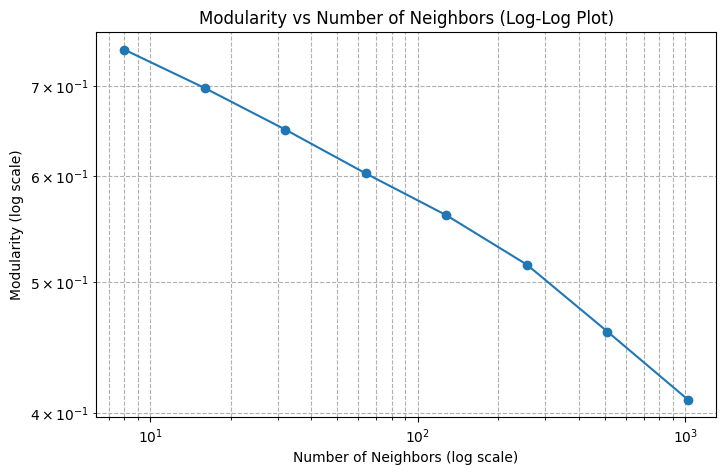

In [16]:
import matplotlib.pyplot as plt
x_vals = [1024, 512, 256, 128, 64, 32, 16, 8]
y_vals = [0.40899185140557104, 0.4595332003903137, 0.5153409989800551, 0.5608485216478408, 0.6024279826772339, 0.6494441198721146, 0.6972847537138163,0.7447457883304428]

plt.figure(figsize=(8, 5))
plt.loglog(x_vals, y_vals, marker='o')
plt.xlabel('Number of Neighbors (log scale)')
plt.ylabel('Modularity (log scale)')
plt.title('Modularity vs Number of Neighbors (Log-Log Plot)')
plt.grid(True, which="both", ls="--")
plt.show()


In [17]:
# subcommunities = []
# offset = 0
# for subgraph in partition.subgraphs():
#     subpartition = la.find_partition(subgraph, la.ModularityVertexPartition, weights='weight', seed=42, n_iterations=-1)
#     membership = [i + offset for i in subpartition.membership]
#     subcommunities.extend(membership)
#     offset += max(subpartition.membership) + 1
#     print(subpartition.modularity)
# communities = subcommunities

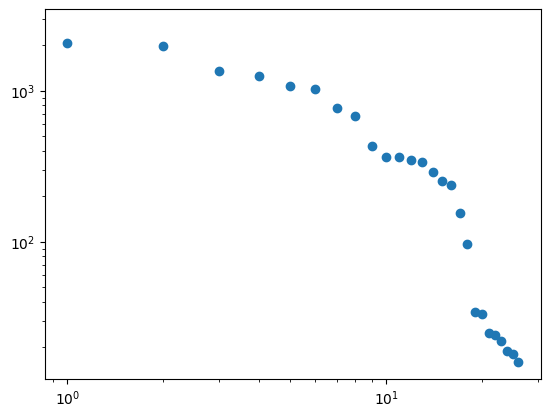

In [18]:
import matplotlib.pyplot as plt

unique_clusters, counts = np.unique(communities, return_counts=True)
cluster_counts = dict(zip(unique_clusters, counts))
plt.loglog(cluster_counts.keys(), cluster_counts.values(), 'o')


In [19]:
indices = [i for i, j in enumerate(communities) if j ==23]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
for index in indices:
    bgg_id = unique_items[index]
    name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    print(name.values[0])

Vem aí a Troika
tummple!
Caravelas II
Millions: The Last Soldier
Lusitania
Carrossel
Porto
Douro 1872
Fado: Duetos e Desgarradas
6 Castles
Rossio
Garum
Estoril 1942: Super Box
Caretos
Lisbon Tram 28
Pessoa
Hercules
Magellan: Elcano
Évora
Moesteiro
Celtae
Lata


In [20]:
# for cluster, count in cluster_counts.items():
#     if count < 20:
#         cluster_indices = np.where(np.array(communities) == cluster)[0]
#         cluster_similarity = np.sum(sparse_matrix[cluster_indices, :], axis=0)
#         cluster_similarity[cluster_indices] = 0
#         target_cluster = communities[np.argmax(cluster_similarity)]
#         for idx in cluster_indices:
#             communities[idx] = target_cluster

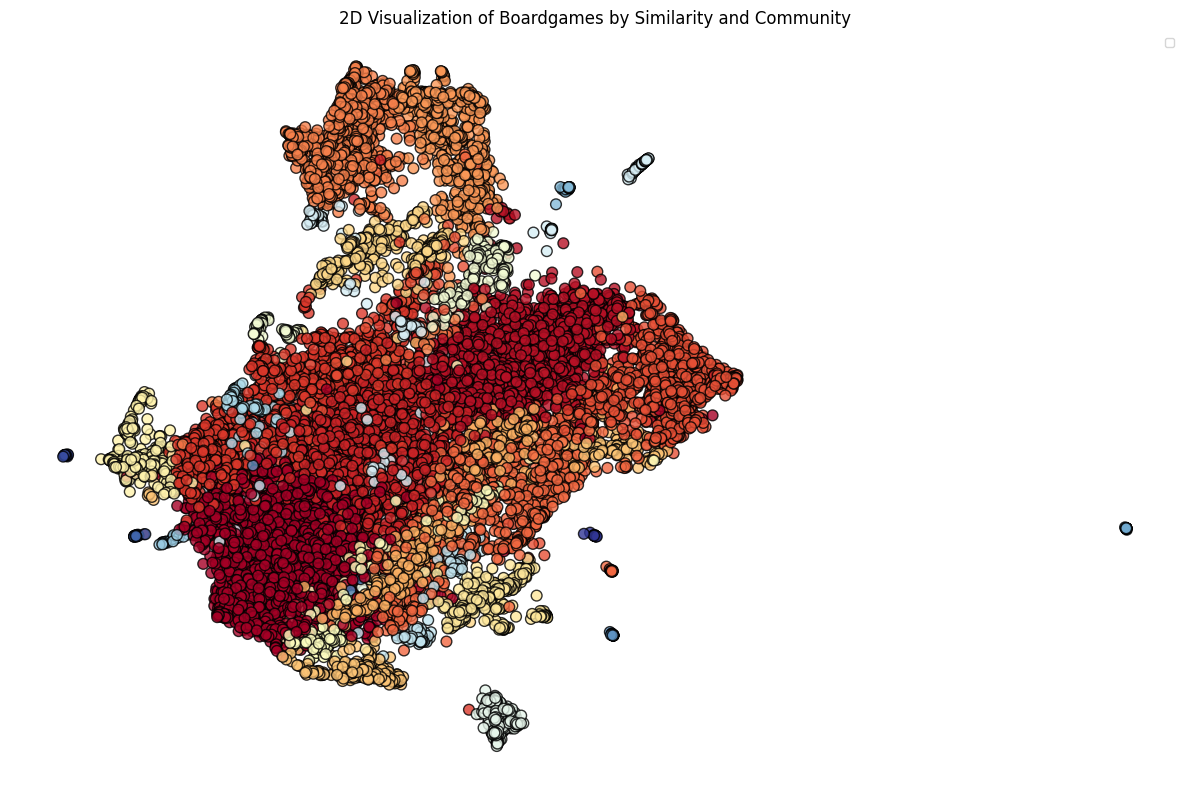

In [21]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# Step 5: Plotting
plt.figure(figsize=(12, 8))

plt.scatter(coords[:, 0], coords[:, 1],c=communities,cmap=plt.cm.RdYlBu ,s=60, alpha=0.8, edgecolor='k')

# Add legend without duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("2D Visualization of Boardgames by Similarity and Community")
plt.axis('off')
plt.tight_layout()
plt.show()

/usr/local/python/3.12.1/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.

<AxesSubplot: >

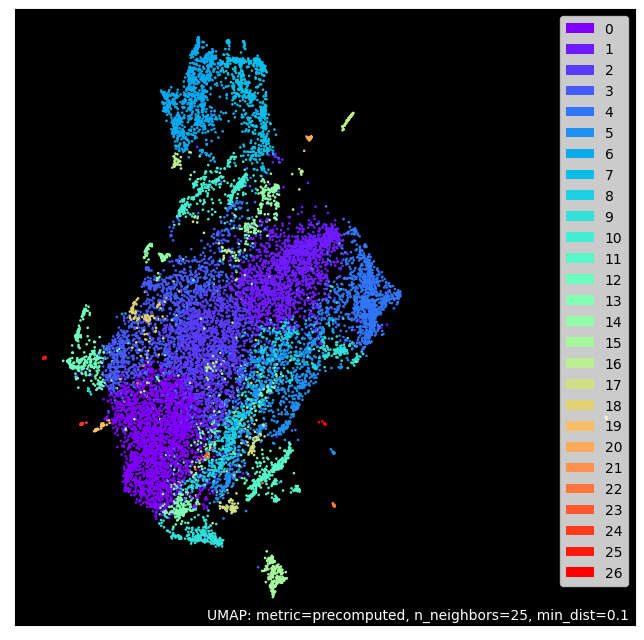

In [22]:
import umap.plot
import numpy as np

# Convert labels to a NumPy array
labels_array = np.array(communities)

# Plot the points
umap.plot.points(mapper, labels=labels_array, theme='fire')

In [23]:
indices = [i for i, j in enumerate(communities)]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
names=[]
ids=[]
i=0
for index in indices:    
    bgg_id = unique_items[index]
    new_var = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]
    name = new_var['name']
    id = new_var['id']
    ids.append(id.values[0])
    names.append(name.values[0])
    i=i+1
hover_data = pd.DataFrame({'Name':np.array(names),'Id':np.array(ids)})



In [24]:
umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=labels_array, hover_data=hover_data, point_size=4,background='black')
umap.plot.show(p)

Loading BokehJS ...

In [25]:
# delete_graph_under_size = 5

In [26]:
# clustered_graph =partition.cluster_graph("random","sum")
# subgraphs = partition.subgraphs()

In [27]:
# j = 0
# dico = {}
# indices_to_delete = []

# for cluster, count in cluster_counts.items():
#     j += 1
#     if count < delete_graph_under_size:
#         cluster_indices = np.where(np.array(communities) == cluster)[0]
#         indices_to_delete.extend(cluster_indices.tolist())
#         cluster_similarity = sparse_matrix[cluster_indices, :]

#         row_idx, col_idx = np.unravel_index(np.argmax(cluster_similarity), cluster_similarity.shape)
#         while col_idx in cluster_indices:
#             cluster_similarity[row_idx, col_idx] = 0
#             row_idx, col_idx = np.unravel_index(np.argmax(cluster_similarity), cluster_similarity.shape)
#         row_idx = cluster_indices[row_idx]
#         dico[row_idx] = (row_idx, col_idx, np.max(cluster_similarity))



In [28]:
# # Map the IDs in indices_to_delete to the corresponding vertex indices in clustered_graph
# ids_to_delete = set(indices_to_delete)
# game_to_delete = [unique_items[id] for id in ids_to_delete]
# vertex_indices_to_delete = [v.index for v in clustered_graph.vs if v["id"] in game_to_delete]
# clustered_graph.delete_vertices(vertex_indices_to_delete)

In [29]:
# for s, (source, target, weight) in dico.items():
#     for idx, subgraph in enumerate(subgraphs):
#         if unique_items[source] in subgraph.vs['id']:
#             source_idx = idx     
#         if unique_items[target] in subgraph.vs['id']:
#             target_idx = idx
#     merged_subgraph = subgraphs[source_idx] + subgraphs[target_idx]
#     source_vertex  = merged_subgraph.vs.find(id=unique_items[source])
#     target_vertex  = merged_subgraph.vs.find(id=unique_items[target])
#     merged_subgraph.add_edge(source_vertex, target_vertex, weight=weight)
#     subgraphs[target_idx]=merged_subgraph
   

In [30]:
# import netbone as nb
# from netbone.filters import boolean_filter
# def extract_backbone_preserve_indices2(subgraph):
#     """
#     Alternative version that maintains original vertex indices exactly
#     by creating a sparse graph with the same index space
#     """
#     # Store original vertex attributes (excluding name and _nx_name)
#     vertex_attrs = {}
#     for v in subgraph.vs:
#         attrs = dict(v.attributes())
#         # Remove unwanted attributes
#         attrs.pop('name', None)
#         attrs.pop('_nx_name', None)
#         vertex_attrs[v.index] = attrs
    
#     # Store original edge attributes
#     edge_attrs = {}
#     for e in subgraph.es:
#         edge_attrs[(e.source, e.target)] = dict(e.attributes())
#         edge_attrs[(e.target, e.source)] = dict(e.attributes())
    
#     # Convert to NetworkX
#     G = subgraph.to_networkx()
    
#     # Apply PMFG backbone extraction
#     pmfg_backbone = nb.pmfg(G)
#     pmfg_backbone = boolean_filter(pmfg_backbone)
    
#     # Create new igraph with preserved indices
#     surviving_nodes = list(pmfg_backbone.nodes())
    
#     # Create vertex index mapping to preserve original indices
#     node_mapping = {node: i for i, node in enumerate(sorted(surviving_nodes))}
#     reverse_mapping = {i: node for node, i in node_mapping.items()}
    
#     # Create new graph
#     backbone_ig = ig.Graph(n=len(surviving_nodes))
    
#     # Add edges
#     edges_to_add = []
#     for edge in pmfg_backbone.edges():
#         source, target = edge
#         new_source = node_mapping[source]
#         new_target = node_mapping[target]
#         edges_to_add.append((new_source, new_target))
    
#     if edges_to_add:
#         backbone_ig.add_edges(edges_to_add)
        
#         # Set edge attributes
#         for i, (new_source, new_target) in enumerate(edges_to_add):
#             orig_source = reverse_mapping[new_source]
#             orig_target = reverse_mapping[new_target]
            
#             # Find original edge attributes
#             edge_key = (orig_source, orig_target)
#             if edge_key not in edge_attrs:
#                 edge_key = (orig_target, orig_source)
            
#             if edge_key in edge_attrs:
#                 for attr_name, attr_value in edge_attrs[edge_key].items():
#                     backbone_ig.es[i][attr_name] = attr_value
    
#     # Set vertex attributes
#     for new_idx, orig_idx in reverse_mapping.items():
#         if orig_idx in vertex_attrs:
#             for attr_name, attr_value in vertex_attrs[orig_idx].items():
#                 backbone_ig.vs[new_idx][attr_name] = attr_value
    
#     return backbone_ig

# def extract_backbone_preserve_indices(subgraph,idx):
#    #try:
#     if subgraph.vcount() < delete_graph_under_size:
#         return None
#     return extract_backbone_preserve_indices2(subgraph)
#     # except:
#     #     print("Subgraph index errored:", idx) 
#     #     return None
 

In [31]:
# from joblib import Parallel, delayed
# subgraphs_backbone = Parallel(n_jobs=-1)(
#     delayed(extract_backbone_preserve_indices)(subgraph,idx) for idx,subgraph in enumerate(subgraphs)
# )
# clustered_graph_backbone = extract_backbone_preserve_indices(clustered_graph,0)

In [32]:
# import os
# import glob

# files = glob.glob("../graph/*")
# for f in files:
#     os.remove(f)

In [33]:
# i=0
# clustered_graph_backbone.write_dot("../graph/clustered_graph.dot")
# for subgraph in subgraphs_backbone:
#     if(subgraph == None or len(subgraph.vs) < delete_graph_under_size):
#         continue
#     subgraph.write_dot(f"../graph/subgraph_{i}.dot")
#     i+=1

In [35]:
import pydot
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed

# ----------------------------
# Helpers
# ----------------------------
def build_id_to_name_map(graph):
    """Build a dictionary mapping node 'id' attribute to node name."""
    return {
        attrs.get("id"): node.get_name()
        for node in graph.get_nodes()
        if (attrs := node.get_attributes()).get("id") is not None
    }

def process_one_graph(j, g, communities, unique_items):
    """Process one subgraph j and return extended pydot graph."""
    # Load DOT file
    graph = pydot.graph_from_dot_file(f"../graph/subgraph_{j}.dot")[0]

    # Precompute caches
    id_to_name_cache = build_id_to_name_map(graph)
    nodes = graph.get_nodes()
    node_attrs = {str(i): nodes[i].get_attributes()["id"] for i in range(len(nodes))}

    node_to_comm = {nid: comm for nid, comm in zip(unique_items, communities)}

    # igraph: build id → vertex_index map for O(1) access
    id_to_vertex = {v["id"]: v.index for v in g.vs}

    # Precompute edges
    min_weight = defaultdict(lambda: float("inf"))
    neighbor_map = defaultdict(set)
    for edge in graph.get_edges():
        w = float(edge.get_attributes().get("weight", float("inf")))
        u, v = edge.get_source(), edge.get_destination()
        if w < min_weight[u]: min_weight[u] = w
        if w < min_weight[v]: min_weight[v] = w
        neighbor_map[u].add(v)
        neighbor_map[v].add(u)

    # Process nodes (sequential inside this process)
    all_results = []
    for target_node, node_id_str in node_attrs.items():
        node_id = int(node_id_str)
        node_index = id_to_vertex[node_id]
        node = g.vs[node_index]

        connected_ids = {node_attrs[n] for n in neighbor_map[target_node]}
        comm_self = node_to_comm[node_id]

        edges_info = []
        for edge_id in g.incident(node_index):
            edge = g.es[edge_id]
            if edge["weight"] >= min_weight[target_node] - 1e-12:
                src, dst = g.vs[edge.source], g.vs[edge.target]
                sourceId, targetId = src["id"], dst["id"]
                linkedNode = sourceId if sourceId != node["id"] else targetId

                # classify edge status
                if str(linkedNode) in connected_ids:
                    status = "Visible"
                elif node_to_comm[linkedNode] == comm_self:
                    status = "Hidden"
                else:
                    status = "External"

                edges_info.append((edge["weight"], src["label"], dst["label"],
                                   sourceId, targetId, status, linkedNode))

        # Build pydot edges/nodes
        for weight, source, target, sourceId, targetId, status, linkedNode in sorted(edges_info):
            if status == "External":
                ghost_id = linkedNode + 1_000_000
                pedge = pydot.Edge(target_node, ghost_id, weight=str(weight), s=status)
                pnode = pydot.Node(
                    ghost_id,
                    # label=source if sourceId != node["id"] else target,
                    id=linkedNode,
                    c=node_to_comm[linkedNode]
                )
                all_results.append((pedge, pnode))

            elif status == "Hidden":
                ghost_id = id_to_name_cache[str(linkedNode)]
                pedge = pydot.Edge(target_node, ghost_id, weight=str(weight), s=status)
                all_results.append((pedge, None))

    # Merge into final graph
    for pedge, pnode in all_results:
        if not graph.get_edge(pedge.get_source(), pedge.get_destination()):
            graph.add_edge(pedge)
        if pnode and not graph.get_node(pnode.get_name()):
            graph.add_node(pnode)

    for node in graph.get_nodes():
        attrs = node.get_attributes()
        if "label" in attrs:
            del node.obj_dict['attributes']['label']
            
    # Save result
    outpath = f"../extendedGraph/subgraph_{j}.dot"
    with open(outpath, "w") as f:
        f.write(graph.to_string())

    return outpath

# ----------------------------
# Parallel over all graphs
# ----------------------------
N_WORKERS = 11  # adjust to your CPU

with ProcessPoolExecutor(max_workers=N_WORKERS) as executor:
    futures = {
        executor.submit(process_one_graph, j, g, communities, unique_items): j
        for j in range(27)
    }
    for fut in as_completed(futures):
        j = futures[fut]
        print(f"Finished subgraph {j} → {fut.result()}")


Finished subgraph 9 → ../extendedGraph/subgraph_9.dot
Finished subgraph 10 → ../extendedGraph/subgraph_10.dot
Finished subgraph 8 → ../extendedGraph/subgraph_8.dot
Finished subgraph 5 → ../extendedGraph/subgraph_5.dot
Finished subgraph 7 → ../extendedGraph/subgraph_7.dot
Finished subgraph 4 → ../extendedGraph/subgraph_4.dot
Finished subgraph 3 → ../extendedGraph/subgraph_3.dot
Finished subgraph 6 → ../extendedGraph/subgraph_6.dot
Finished subgraph 11 → ../extendedGraph/subgraph_11.dot
Finished subgraph 12 → ../extendedGraph/subgraph_12.dot
Finished subgraph 1 → ../extendedGraph/subgraph_1.dot
Finished subgraph 2 → ../extendedGraph/subgraph_2.dot
Finished subgraph 13 → ../extendedGraph/subgraph_13.dot
Finished subgraph 14 → ../extendedGraph/subgraph_14.dot
Finished subgraph 15 → ../extendedGraph/subgraph_15.dot
Finished subgraph 17 → ../extendedGraph/subgraph_17.dot
Finished subgraph 16 → ../extendedGraph/subgraph_16.dot
Finished subgraph 18 → ../extendedGraph/subgraph_18.dot
Finished s